In [1]:
# import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
from collections import Counter


torch.manual_seed(0)

# 1.Data Preprocess

In [2]:
import random
import copy
import numpy as np

random.seed(0)

def random_split(dataset, split_size1, split_size2, transform_1=None, transform_2=None):
    indexs = list(range(split_size1 + split_size2))
    indexs_1 = random.sample(indexs, split_size1)
    indexs_1.sort()
    indexs_2 = list(filter(lambda x: x not in indexs_1, indexs))

    dataset_1 = copy.copy(dataset)
    dataset_2 = copy.copy(dataset)

    dataset_1.data = np.array([dataset.data[i] for i in indexs_1])
    dataset_1.targets = [dataset.targets[i] for i in indexs_1]
    dataset_1.transform = transform_1

    dataset_2.data = np.array([dataset.data[i] for i in indexs_2])
    dataset_2.targets = [dataset.targets[i] for i in indexs_2]
    dataset_2.transform = transform_2

    return (dataset_1, dataset_2)


In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_size, val_size = 40000, 10000

wholeset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

trainset, valset = random_split(wholeset, train_size, val_size, transform_train, transform_val)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(
    valset, batch_size=256, shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
for i in range(10):
    print('Label: %5s,  Trainset Samples: %4d,  Valset Samples: %4d,  Testset Samples: %4d' %\
        (classes[i], trainset.targets.count(i), valset.targets.count(i), testset.targets.count(i)))

Label: plane,  Trainset Samples: 4016,  Valset Samples:  984,  Testset Samples: 1000
Label:   car,  Trainset Samples: 4009,  Valset Samples:  991,  Testset Samples: 1000
Label:  bird,  Trainset Samples: 3976,  Valset Samples: 1024,  Testset Samples: 1000
Label:   cat,  Trainset Samples: 3996,  Valset Samples: 1004,  Testset Samples: 1000
Label:  deer,  Trainset Samples: 4022,  Valset Samples:  978,  Testset Samples: 1000
Label:   dog,  Trainset Samples: 4009,  Valset Samples:  991,  Testset Samples: 1000
Label:  frog,  Trainset Samples: 3970,  Valset Samples: 1030,  Testset Samples: 1000
Label: horse,  Trainset Samples: 4033,  Valset Samples:  967,  Testset Samples: 1000
Label:  ship,  Trainset Samples: 3971,  Valset Samples: 1029,  Testset Samples: 1000
Label: truck,  Trainset Samples: 3998,  Valset Samples: 1002,  Testset Samples: 1000


# 2.Training

In [5]:
# Training
def train(epoch, net, criterion, trainloader, optimizer, scheduler):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
          print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

In [6]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total

In [7]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')

In [8]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [32]:
# main body
config = {
    'id': '0',
    'lr': 0.01,
    'lr_schedule': 'cosine',
    'weight_decay': 5e-4,
    'epochs': 10
}

In [33]:
net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=0.9, weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

for epoch in range(config['epochs']):
    train_loss, train_acc = train(epoch, net, criterion, trainloader, optimizer, scheduler)
    val_loss, val_acc = test(epoch, net, criterion, valloader)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss, train_acc, val_loss, val_acc))

test_loss, test_acc = test(epoch, net, criterion, testloader)
print("test loss : %0.4f, test accuracy : %2.2f" % (test_loss, test_acc))


Epoch: 0
iteration :  50, loss : 1.9932, accuracy : 26.41
iteration : 100, loss : 1.8137, accuracy : 32.33
iteration : 150, loss : 1.7198, accuracy : 36.28
iteration : 200, loss : 1.6425, accuracy : 39.47
iteration : 250, loss : 1.5785, accuracy : 42.06
iteration : 300, loss : 1.5141, accuracy : 44.55
Epoch :   0, training loss : 1.4998, training accuracy : 45.09, val loss : 1.2648, val accuracy : 55.53

Epoch: 1
iteration :  50, loss : 1.1135, accuracy : 59.88
iteration : 100, loss : 1.1068, accuracy : 60.33
iteration : 150, loss : 1.0726, accuracy : 61.63
iteration : 200, loss : 1.0433, accuracy : 62.66
iteration : 250, loss : 1.0206, accuracy : 63.42
iteration : 300, loss : 0.9966, accuracy : 64.30
Epoch :   1, training loss : 0.9918, training accuracy : 64.52, val loss : 1.1597, val accuracy : 62.97

Epoch: 2
iteration :  50, loss : 0.8414, accuracy : 70.62
iteration : 100, loss : 0.8273, accuracy : 70.88
iteration : 150, loss : 0.8106, accuracy : 71.34
iteration : 200, loss : 0.7

# 3.Visualization

In [34]:
import matplotlib.pyplot as plt
import os

output_path = './output/'

if not os.path.exists(output_path):
    os.mkdir(output_path)

dir_path = output_path + config['id'] + '/'

if not os.path.exists(dir_path):
    os.mkdir(dir_path)

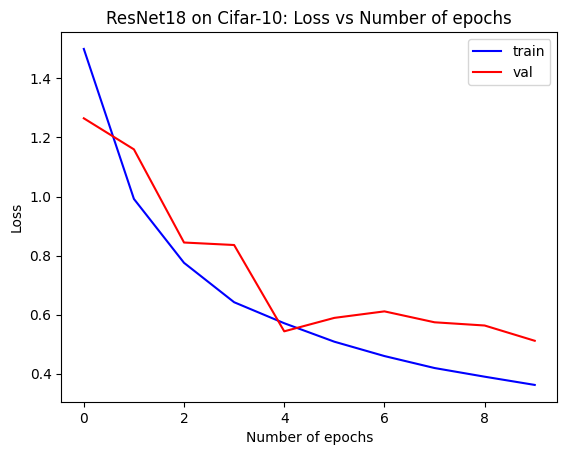

In [35]:
plt.plot(range(len(train_loss_list)), train_loss_list, 'b')
plt.plot(range(len(val_loss_list)), val_loss_list, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("ResNet18 on Cifar-10: Loss vs Number of epochs")
plt.legend(['train', 'val'])
plt.savefig(dir_path + 'loss.png')
plt.savefig(dir_path + 'loss.jpg')
plt.show()

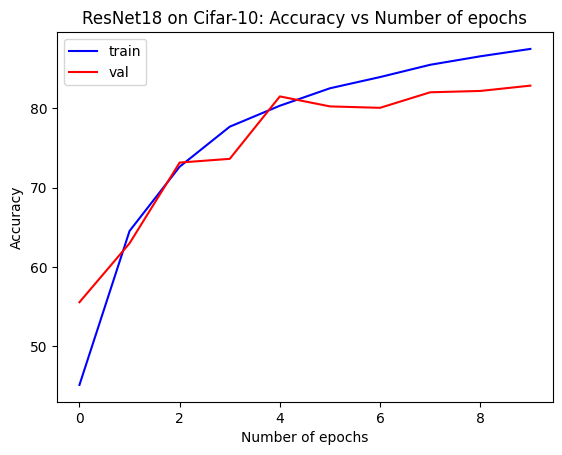

In [36]:
plt.plot(range(len(train_acc_list)), train_acc_list, 'b')
plt.plot(range(len(val_acc_list)), val_acc_list, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("ResNet18 on Cifar-10: Accuracy vs Number of epochs")
plt.legend(['train', 'val'])
plt.savefig(dir_path + 'accuracy.png')
plt.savefig(dir_path + 'accuracy.jpg')
plt.show()

In [37]:
import pandas as pd

In [41]:
logs = [{
    'epoch': i,
    'train_loss': train_loss_list[i],\
    'train_acc': train_acc_list[i],
    'val_loss': val_loss_list[i], 
    'val_acc': val_acc_list[i]
    } for i in range(config['epochs'])
]

In [44]:
df = pd.DataFrame(logs,\
     columns = ['epoch','train_loss','train_acc', 'val_loss', 'val_acc'])

In [45]:
df.to_csv(dir_path + 'logs.csv')